In [172]:
import torch
import wandb
import collections

api = wandb.Api()

runs = api.runs("pmin/crcns-train_net.py", 
                {"$and": 
                 [
                     {"config.dataset": "pvc4"},
                     {"state": "finished"},
                ]
                }
               )

archives = {'gaborpyramid2d': {},
            'xception2d': {},
            'gaborpyramid3d': {}}

print("Found %i" % len(runs))
for i in runs:
    if i.config['single_cell'] in archives[i.config['submodel']]:
        continue
    
    wandb.restore('model.pt', '/'.join(i.path), True)
    restored = torch.load('model.pt')
    archives[i.config['submodel']][i.config['single_cell']] = {'tune_corr': i.summary['tune_corr'],
                                                               'config': i.config,
                                                               'weights': restored}
    print(i.config['single_cell'])
    print(i.summary['tune_corr'])

Found 80
-1
[0.31634825468063354, 0.4738776683807373, 0.33951863646507263, 0.2302042692899704, 0.387041836977005, 0.1634284406900406, 0.32499369978904724, 0.2455165982246399, 0.06549621373414993, 0.33159735798835754, 0.2974044382572174, 0.15329502522945404, 0.2584822177886963, 0.023154620081186295, 0.15719740092754364, 0.06547610461711884, 0.34590765833854675, 0.1437617987394333, 0.0974467471241951, 0.26680365204811096, -0.011922912672162056, 0.007167274132370949, 0.002275548642501235, 0.22133924067020416, -0.015989109873771667]
2
0.26716169714927673
-1
[0.2335139513015747, 0.14390529692173004, 0.3501727879047394, 0.3197035491466522, 0.11592502892017365, 0.012957148253917694, 0.01105730514973402, 0.06804584711790085, 0.1126408725976944, 0.014443389140069485, 0.07681449502706528, 0.01677555963397026, 0.2160910665988922, 0.13729658722877502, 0.11186304688453674, 0.1709665805101395, 0.002656784141436219, 0.195230633020401, 0.464754581451416, 0.2924261689186096, 0.19660739600658417, 0.3332

(-1.1, 1.1)

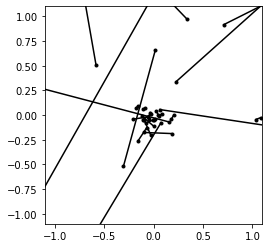

In [171]:
x_all_at_once = archives['gaborpyramid2d'][-1]['weights']['sampler.wx'].cpu().numpy()
x_one_by_one = np.array([archives['gaborpyramid2d'][x]['weights']['sampler.wx'].cpu().numpy() for x in range(25)]).squeeze()
y_all_at_once = archives['gaborpyramid2d'][-1]['weights']['sampler.wy'].cpu().numpy()
y_one_by_one = np.array([archives['gaborpyramid2d'][x]['weights']['sampler.wy'].cpu().numpy() for x in range(25)]).squeeze()
#archives['gaborpyramid2d'][0]['config']['learning_rate']
plt.plot(np.stack([x_all_at_once, x_one_by_one], axis=0), 
         np.stack([y_all_at_once, y_one_by_one], axis=0), 'k.-')
plt.axis('square')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])

In [166]:
[x_all_at_once, x_one_by_one]

[array([ 0.18238145,  1.0866314 ,  0.00759659, -0.10613997, -0.71515685,
        -1.459469  ,  1.3236212 , -0.05640861, -0.04596966,  0.34030446,
         2.143676  ,  0.709235  , -0.11134848,  0.00410185,  0.02657548,
        -1.3330803 , -1.6518818 , -0.09665827,  0.08307133, -0.0694584 ,
        -0.30469847, -0.17413002, -1.0483379 ,  0.20523083, -0.07756416],
       dtype=float32),
 array([[-9.9157296e-02],
        [ 1.0336617e+00],
        [-1.2724528e-03],
        [-8.6366288e-02],
        [-5.8164388e-01],
        [ 3.1989318e-01],
        [ 2.2802328e-01],
        [-2.0692144e-01],
        [-3.3334795e-02],
        [-1.0469531e+00],
        [ 6.3262224e-02],
        [ 3.3106732e+00],
        [-2.7937867e-02],
        [-1.1491196e-01],
        [ 4.8468444e-02],
        [ 1.5786837e-01],
        [-1.2929194e+00],
        [-3.0077750e-02],
        [ 5.9524819e-02],
        [-1.5480994e-01],
        [ 1.7667795e-02],
        [-1.5860979e-01],
        [ 7.5761326e-02],
        [ 1.8

Tune correlation, all at once, xception2d: 0.1235
Tune correlation, cell-by-cell, xception2d: 0.1751


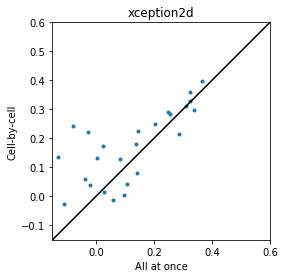

Tune correlation, all at once, gaborpyramid2d: 0.1656
Tune correlation, cell-by-cell, gaborpyramid2d: 0.1860


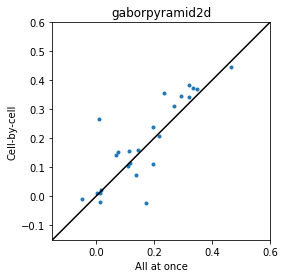

In [143]:
import matplotlib.pyplot as plt

for rep in ['xception2d', 'gaborpyramid2d']:
    tune_corr_all = archives[rep][-1]['tune_corr']
    tune_corr_cell_by_cell = [(k, v['tune_corr']) for k, v in archives[rep].items() if k > -1]
    tune_corr_cell_by_cell = [x[1] for x in sorted(tune_corr_cell_by_cell)]
    plt.plot(tune_corr_all, tune_corr_cell_by_cell, '.')
    plt.plot([-1, 1], [-1, 1], 'k-')
    plt.axis('square')
    plt.xlim((-.15, .6))
    plt.ylim((-.15, .6))
    plt.xlabel('All at once')
    plt.ylabel('Cell-by-cell')
    plt.title(rep)
    print(f"Tune correlation, all at once, {rep}: {np.mean(tune_corr_all):.4f}")
    print(f"Tune correlation, cell-by-cell, {rep}: {np.mean(tune_corr_cell_by_cell):.4f}")
    plt.show()

1
2
3
4
5
6
7
8
9


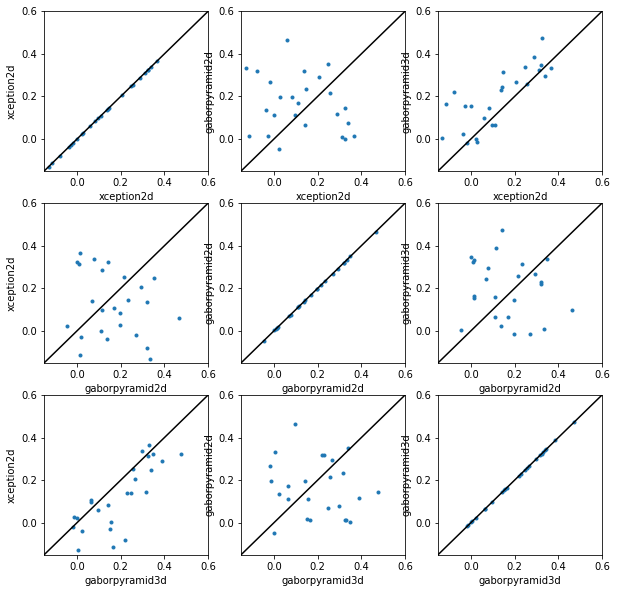

In [187]:
plt.figure(figsize=(10, 10))
reps = ['xception2d', 'gaborpyramid2d', 'gaborpyramid3d']
nrep = 3
for i in range(nrep):
    for j in range(0, nrep):
        rep0 = reps[i]
        rep1 = reps[j]
        plt.subplot(nrep, nrep, 1 + j + i * nrep)
        print(1 + j + i * nrep)
        plt.plot(archives[rep0][-1]['tune_corr'], archives[rep1][-1]['tune_corr'], '.')
        plt.xlabel(rep0)
        plt.ylabel(rep1)
        plt.plot([-1, 1], [-1, 1], 'k-')
        plt.xlim((-.15, .6))
        plt.ylim((-.15, .6))

#for rep in ['xception2d', 'gaborpyramid2d']:
#    tune_corr_all = archives[rep][-1]['tune_corr']

(-0.12, 0.5)

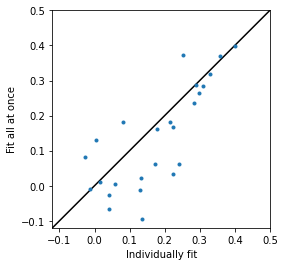

In [112]:
all_at_once = [0.1678023338317871,
               0.37069717049598694,
               0.2859063744544983,
               0.16201408207416534,
               0.1804608851671219,
               0.08193636685609818,
               0.28480473160743713,
               0.18251098692417145,
               0.1291564702987671,
               0.3979525566101074,
               0.26405853033065796,
               0.03389165922999382,
               0.2364319413900375,
               0.0045745414681732655,
               0.02219552919268608,
               -0.06534221768379211,
               0.31926828622817993,
               -0.010949542745947838,
               -0.00940705556422472,
               0.37300461530685425,
               0.01107801217585802,
               -0.094401553273201,
               0.062314119189977646,
               0.06088846176862717,
               -0.027850590646266937]

all_at_once_pretrained = [0.146110400557518,0.32512882351875305,0.2490551471710205,0.13805796205997467,0.2879319489002228,-0.11183082312345503,0.31194233894348145,0.141983300447464,0.0982915461063385,0.36537039279937744,0.3389202356338501,-0.026962850242853165,0.25463470816612244,-0.03682025149464607,0.001990905497223139,0.10854241251945496,0.3230203688144684,0.0827552080154419,0.059587348252534866,0.2049235701560974,0.02760285697877407,-0.12945596873760223,0.02471204660832882,-0.0783606693148613,-0.01916531473398209]
individual = np.array([x['tune_corr'] for x in archives.values()])

plt.plot([-1, 1], [-1, 1], 'k-')
plt.plot(individual[::-1], all_at_once, '.')
plt.xlabel('Individually fit')
plt.ylabel('Fit all at once')
plt.axis('square')
plt.xlim((-0.12, 0.5))
plt.ylim((-0.12, 0.5))

In [114]:
np.mean(all_at_once_pretrained)

0.12351862573996186

In [94]:
import numpy as np

targets = sorted([(v['tune_corr'], v['weights']) for v in archives.values()])[:-17:-1]
ws = []
for _, vals in targets:
    idx = np.argsort(np.random.rand(8))[:4:]
    ws.append(vals['subnet.conv1.weight'][idx, :, :, :].cpu().detach().numpy())

W = np.concatenate(ws, axis=0)
np.save('pretrained/gaborpyramid2d.npy', W)

In [56]:
model_file.mode = 'rb'
model_file

<_io.TextIOWrapper name='D:\\Documents\\brain-scorer\\model.pt' mode='rb' encoding='cp1252'>

In [93]:
len(ws)

15

In [38]:
f = i.file('model.pt')
f.

{'_step': 0, '_runtime': 1, 'tune_corr': 0.04770519211888313, '_timestamp': 1608354193}